<a href="https://colab.research.google.com/github/dmosh/building_density/blob/main/density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Loading neccessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import re
import io
from google.cloud import storage
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, Flatten, GlobalAveragePooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [ ]:
# mount your drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#!pip install gsutil
#!curl http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=UuTMZWJCG6YdrVnGFjaVEpaYpTe0Db&prompt=consent&access_type=offline&code_challenge=mrskjLJT3iWHj9gjkDg1thV0_PTz5NhKaugVJMvlb2I&code_challenge_method=S256

Enter authorization code: 4/0AfJohXm_vuB6ZXcoDM-cvh3Pepd1u3pRqActCFMXo9SDogdJuKVZ5J5tHNt86FMFSYhuZg

You are now logged in as [moshmoses3@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [2]:
# Create a Cloud Storage client
storage_client = storage.Client()

# Get the bucket where the training data is stored
bucket = storage_client.bucket('xcob-bucket-1')

# Get the object where the training data is stored
object_training = bucket.blob('dataset/training/training.csv')

# Download the training data from Cloud Storage
training_data = object_training.download_as_string().decode('utf-8')

# Create a StringIO object from the training data
with io.StringIO(training_data) as f:
    training = pd.read_csv(f)

# Get the object where the validation data is stored
object_testing = bucket.blob('dataset/test/testing.csv')

# Download the validation data from Cloud Storage
testing_data = object_testing.download_as_string().decode('utf-8')

# Create a StringIO object from the validation data
with io.StringIO(testing_data) as f:
    testing = pd.read_csv(f)


# Get the object where the testing data is stored
object_test = bucket.blob('dataset/samples/samples.csv')

# Download the testing data from Cloud Storage
test_data = object_test.download_as_string().decode('utf-8')

# Create a StringIO object from the testing data
with io.StringIO(test_data) as f:
    test = pd.read_csv(f)

In [3]:
#training.head()
test.head()
#print(training.shape)
#print(testing.shape)


,input,label
0,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
1,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
2,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
3,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
4,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...


In [ ]:
#Access sample images
# Access the "input" and "label" columns
input_paths = training["input"]
label_paths = training["label"]

#Access validation images
tinput_paths = testing["input"]
tlabel_paths = testing["label"]

In [ ]:
# Initialize a client to interact with GCS (make sure you've set up GCS credentials)
client = storage.Client()

def visualize_random_image_pair(input_paths, label_paths):
    # Select a random index
    random_index = random.randint(0, len(input_paths) - 1)

    # Get the image paths at the random index
    input_path = input_paths[random_index]
    label_path = label_paths[random_index]

    # Extract file names from image paths
    input_filename = os.path.basename(input_path)
    label_filename = os.path.basename(label_path)

    # Load images from GCS
    input_blob = client.get_bucket('xcob-bucket-1').blob(input_path)
    label_blob = client.get_bucket('xcob-bucket-1').blob(label_path)

    # Download image data from GCS
    input_image_data = input_blob.download_as_string()
    label_image_data = label_blob.download_as_string()

    # Decode the image data using OpenCV
    img1 = cv2.imdecode(np.frombuffer(input_image_data, np.uint8), -1)
    img2 = cv2.imdecode(np.frombuffer(label_image_data, np.uint8), -1)

    # Plot the random image pair with titles
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"{input_filename}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"{label_filename}")
    plt.axis("off")
    plt.show()

# Read the CSV file into a DataFrame
df = pd.read_csv('dataset/training/training.csv')

# Extract the input and label paths from the DataFrame
input_paths = df['input'].tolist()
label_paths = df['label'].tolist()

# Visualize a random pair of images from the training data
visualize_random_image_pair(input_paths, label_paths)


In [4]:
# Load data for training, validation and testing
desired_height, desired_width = (148, 148)

# Function to load, preprocess, and normalise an image
def load_preprocess_and_normalize(image_path, is_label=False):
    # Ensure the input is a string (file path)
    image_path = tf.convert_to_tensor(image_path, dtype=tf.string)

    # Load the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)  # Decode as RGB image

    # Calculate padding if necessary
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    pad_height = tf.maximum(0, desired_height - height)
    pad_width = tf.maximum(0, desired_width - width)


    # Apply padding to smaller images
    img = tf.image.pad_to_bounding_box(img, pad_height // 2, pad_width // 2, desired_height, desired_width)

    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32
    if not is_label:
        img = (img * 2.0) - 1.0  # Normalise to [-1, 1] for images
    else:
        img = tf.round(img)  # Ensure binary values for masks/labels
        img = tf.reduce_sum(img) / 3  # Sum the mask values and divide by 3 to account for the 3 channels (this gives a rough building density value)

    return img

# Specify your GCS bucket path
gcs_bucket_path = 'gs://xcob-bucket-1/'

# Update the CSV data with GCS bucket path
training['input'] = gcs_bucket_path + training['input']
training['label'] = gcs_bucket_path + training['label']
testing['input'] = gcs_bucket_path + testing['input']
testing['label'] = gcs_bucket_path + testing['label']
test['input'] = gcs_bucket_path + test['input']
test['label'] = gcs_bucket_path + test['label']

# Load the CSV files containing image paths
train_data = training
val_data = testing
test_data = test

# Create TensorFlow datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["input"], train_data["label"]))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data["input"], val_data["label"]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data["input"], test_data["label"]))

# Parallelizing Data Loading
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1),
                                                  load_preprocess_and_normalize(x2, is_label=True)),
                                  num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1),
                                                load_preprocess_and_normalize(x2, is_label=True)),
                                num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1),
                                                load_preprocess_and_normalize(x2, is_label=True)),
                                num_parallel_calls=AUTOTUNE)

# Caching: If you have enough memory, you can uncomment the next two lines
# train_dataset = train_dataset.cache()
# test_dataset = test_dataset.cache()

# Define batch size and shuffle the training dataset
batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)

# Prefetching
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)


In [5]:
# Custom architecture
input_layer = Input(shape=(148, 148, 3), name='input_1')

# Example: Using the named input layer in your model
base_model = ResNet152(input_tensor=input_layer, include_top=False, weights=None)

# Define the L2 regularization strength
l2_strength = 1e-3  # or 1e-4 or Adjust the strength as needed

# Replace Flatten and Dense layers with convolutional layers with L2 regularization
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength))(base_model.output)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength))(x)

# Modify the output layer to produce building density
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='linear', kernel_regularizer=l2(l2_strength), name='building_density')(x)

# Create the custom ResNet-152 model for building density estimation
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with mean squared error (MSE) loss and an appropriate optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Print a summary of the model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 148, 148, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 154, 154, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 74, 74, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 74, 74, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
#tf.keras.backend.clear_session()
!nvidia-smi
print(tf.test.is_gpu_available())

In [6]:
# This function will handle the uploading of the model to GCS
import subprocess

# This function will handle the uploading of the model to GCS using gsutil
def upload_model_to_gcs_using_gsutil(local_path, gcs_path):
    command = f"gsutil cp {local_path} {gcs_path}"
    process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    if error:
        print("Error while uploading:", error)
    else:
        print(f"Model successfully uploaded to {gcs_path}")

# Define a custom callback to upload the best model to GCS using gsutil
class GCSModelCheckpointUsingGSUTIL(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(GCSModelCheckpointUsingGSUTIL, self).__init__()
        self.best = float('inf')  # best validation loss
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best:
            self.best = current_val_loss
            # Save model to a temporary .h5 file
            temp_filename = "temporary_best_model.h5"
            self.model.save(temp_filename)
            # Upload to GCS using gsutil
            upload_model_to_gcs_using_gsutil(temp_filename, self.filepath)
            # Clean up the temporary file
            os.remove(temp_filename)

Epoch 1/100
696/696 [==============================] - ETA: 0s - loss: 277520.2188 - mean_absolute_error: 245.6663

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1919s 606ms/step - loss: 277520.2188 - mean_absolute_error: 245.6663 - val_loss: 190548.7812 - val_mean_absolute_error: 253.5975 - lr: 0.0010
Epoch 2/100
696/696 [==============================] - ETA: 0s - loss: 204213.0938 - mean_absolute_error: 218.0785

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1456s 530ms/step - loss: 204213.0938 - mean_absolute_error: 218.0785 - val_loss: 166641.7344 - val_mean_absolute_error: 208.4539 - lr: 0.0010
Epoch 3/100
696/696 [==============================] - 1418s 510ms/step - loss: 156349.3281 - mean_absolute_error: 196.1601 - val_loss: 182332.5156 - val_mean_absolute_error: 191.4021 - lr: 0.0010
Epoch 4/100
696/696 [==============================] - 1418s 508ms/step - loss: 132037.8906 - mean_absolute_error: 179.8318 - val_loss: 960116.8750 - val_mean_absolute_error: 274.9716 - lr: 0.0010
Epoch 5/100
696/696 [==============================] - 1428s 507ms/step - loss: 132109.2656 - mean_absolute_error: 179.9078 - val_loss: 191720.5469 - val_mean_absolute_error: 254.0950 - lr: 0.0010
Epoch 6/100
696/696 [==============================] - ETA: 0s - loss: 80609.6797 - mean_absolute_error: 150.4767

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1422s 517ms/step - loss: 80609.6797 - mean_absolute_error: 150.4767 - val_loss: 98669.8203 - val_mean_absolute_error: 160.8477 - lr: 2.0000e-04
Epoch 7/100
696/696 [==============================] - ETA: 0s - loss: 68763.2109 - mean_absolute_error: 138.7554

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1408s 525ms/step - loss: 68763.2109 - mean_absolute_error: 138.7554 - val_loss: 93760.9219 - val_mean_absolute_error: 153.0518 - lr: 2.0000e-04
Epoch 8/100
696/696 [==============================] - 1399s 501ms/step - loss: 60840.7188 - mean_absolute_error: 133.4163 - val_loss: 141534.0938 - val_mean_absolute_error: 241.8437 - lr: 2.0000e-04
Epoch 9/100
696/696 [==============================] - 1395s 504ms/step - loss: 60538.3594 - mean_absolute_error: 131.8784 - val_loss: 95159.7891 - val_mean_absolute_error: 149.9770 - lr: 2.0000e-04
Epoch 10/100
696/696 [==============================] - 1404s 509ms/step - loss: 55072.3984 - mean_absolute_error: 126.7739 - val_loss: 107751.8516 - val_mean_absolute_error: 158.3139 - lr: 2.0000e-04
Epoch 11/100
696/696 [==============================] - ETA: 0s - loss: 44545.6797 - mean_absolute_error: 118.0880

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1415s 514ms/step - loss: 44545.6797 - mean_absolute_error: 118.0880 - val_loss: 86149.3281 - val_mean_absolute_error: 144.1391 - lr: 4.0000e-05
Epoch 12/100
696/696 [==============================] - ETA: 0s - loss: 42210.2617 - mean_absolute_error: 115.2145

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1418s 525ms/step - loss: 42210.2617 - mean_absolute_error: 115.2145 - val_loss: 83500.4844 - val_mean_absolute_error: 140.4561 - lr: 4.0000e-05
Epoch 13/100
696/696 [==============================] - ETA: 0s - loss: 40626.9570 - mean_absolute_error: 113.0096

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1402s 515ms/step - loss: 40626.9570 - mean_absolute_error: 113.0096 - val_loss: 82412.5859 - val_mean_absolute_error: 138.1913 - lr: 4.0000e-05
Epoch 14/100
696/696 [==============================] - 1397s 506ms/step - loss: 39402.7930 - mean_absolute_error: 111.8619 - val_loss: 84438.1250 - val_mean_absolute_error: 143.4652 - lr: 4.0000e-05
Epoch 15/100
696/696 [==============================] - 1400s 503ms/step - loss: 37460.2031 - mean_absolute_error: 110.0399 - val_loss: 83782.8438 - val_mean_absolute_error: 139.3577 - lr: 4.0000e-05
Epoch 16/100
696/696 [==============================] - 1408s 507ms/step - loss: 36649.0039 - mean_absolute_error: 108.4168 - val_loss: 82903.2188 - val_mean_absolute_error: 135.4163 - lr: 4.0000e-05
Epoch 17/100
696/696 [==============================] - ETA: 0s - loss: 34160.6406 - mean_absolute_error: 105.8831

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5
696/696 [==============================] - 1414s 520ms/step - loss: 34160.6406 - mean_absolute_error: 105.8831 - val_loss: 81018.0781 - val_mean_absolute_error: 135.0089 - lr: 8.0000e-06
Epoch 18/100
696/696 [==============================] - 1403s 506ms/step - loss: 34073.4180 - mean_absolute_error: 105.4770 - val_loss: 81113.6250 - val_mean_absolute_error: 135.7945 - lr: 8.0000e-06
Epoch 19/100
696/696 [==============================] - 1617s 547ms/step - loss: 33365.9258 - mean_absolute_error: 104.9409 - val_loss: 82368.4453 - val_mean_absolute_error: 136.7026 - lr: 8.0000e-06
Epoch 20/100
696/696 [==============================] - 1458s 523ms/step - loss: 33314.2578 - mean_absolute_error: 104.8228 - val_loss: 82228.3047 - val_mean_absolute_error: 135.9233 - lr: 8.0000e-06
Epoch 21/100
696/696 [==============================] - 1429s 509ms/step - loss: 32719.9648 - mean_absolute_error: 104.1929 

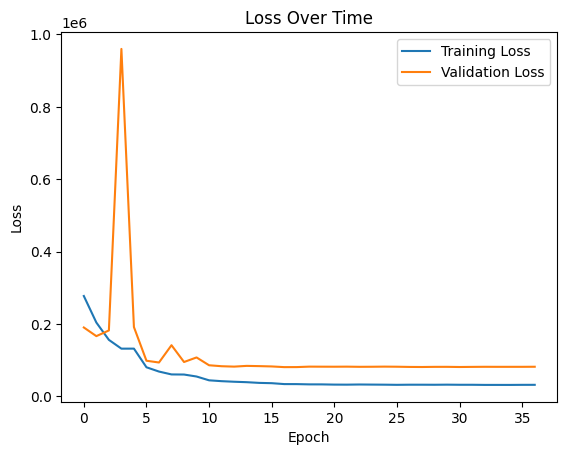

In [8]:
# Now we can define our training setup
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

checkpoint_path = "gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
num_epochs = 100
patience = 20

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Replace the normal checkpoint callback with our custom GCS checkpoint
gcs_checkpoint = GCSModelCheckpointUsingGSUTIL(checkpoint_path)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[gcs_checkpoint, early_stopping, reduce_lr]
)

# Training complete
print("Training finished.")

# After training, you can analyze or visualize the loss values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [6]:
#Download saved model
def download_file_from_gcs(gcs_path, local_path):
    client = storage.Client()
    bucket_name = gcs_path.split("//")[1].split("/")[0]
    blob_name = gcs_path.split(bucket_name + "/")[1]
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(local_path)

checkpoint_path = "gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5"
local_model_path = "downloaded_model.h5"
download_file_from_gcs(checkpoint_path, local_model_path)

model = tf.keras.models.load_model(local_model_path)

In [8]:
# Unfreeze all layers
for layer in model.layers:
    layer.trainable = True

# Compile the model with a low learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Define the checkpoint path again (you might want to use a different name to avoid overwriting)
checkpoint_path = "fine_tuned_resnet_weights.h5"

# Create the custom checkpoint
#gcs_checkpoint = GCSModelCheckpointUsingGSUTIL(checkpoint_path)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

#model.load_weights(checkpoint_path)

# Add other callbacks if needed (like ReduceLROnPlateau, EarlyStopping, etc.)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[model_checkpoint, reduce_lr, early_stopping]
)

Epoch 1/100
696/696 [==============================] - ETA: 0s - loss: 34031.2617 - mean_absolute_error: 105.4131
Epoch 1: val_loss improved from inf to 83985.35938, saving model to fine_tuned_resnet_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


696/696 [==============================] - 1658s 553ms/step - loss: 34031.2617 - mean_absolute_error: 105.4131 - val_loss: 83985.3594 - val_mean_absolute_error: 137.3173 - lr: 1.0000e-05
Epoch 2/100
696/696 [==============================] - ETA: 0s - loss: 33592.1367 - mean_absolute_error: 105.0726
Epoch 2: val_loss improved from 83985.35938 to 82235.85938, saving model to fine_tuned_resnet_weights.h5
696/696 [==============================] - 1374s 512ms/step - loss: 33592.1367 - mean_absolute_error: 105.0726 - val_loss: 82235.8594 - val_mean_absolute_error: 136.2582 - lr: 1.0000e-05
Epoch 3/100
696/696 [==============================] - ETA: 0s - loss: 33017.0391 - mean_absolute_error: 104.1267
Epoch 3: val_loss improved from 82235.85938 to 80481.28125, saving model to fine_tuned_resnet_weights.h5
696/696 [==============================] - 1338s 499ms/step - loss: 33017.0391 - mean_absolute_error: 104.1267 - val_loss: 80481.2812 - val_mean_absolute_error: 135.4311 - lr: 1.0000e-05
E

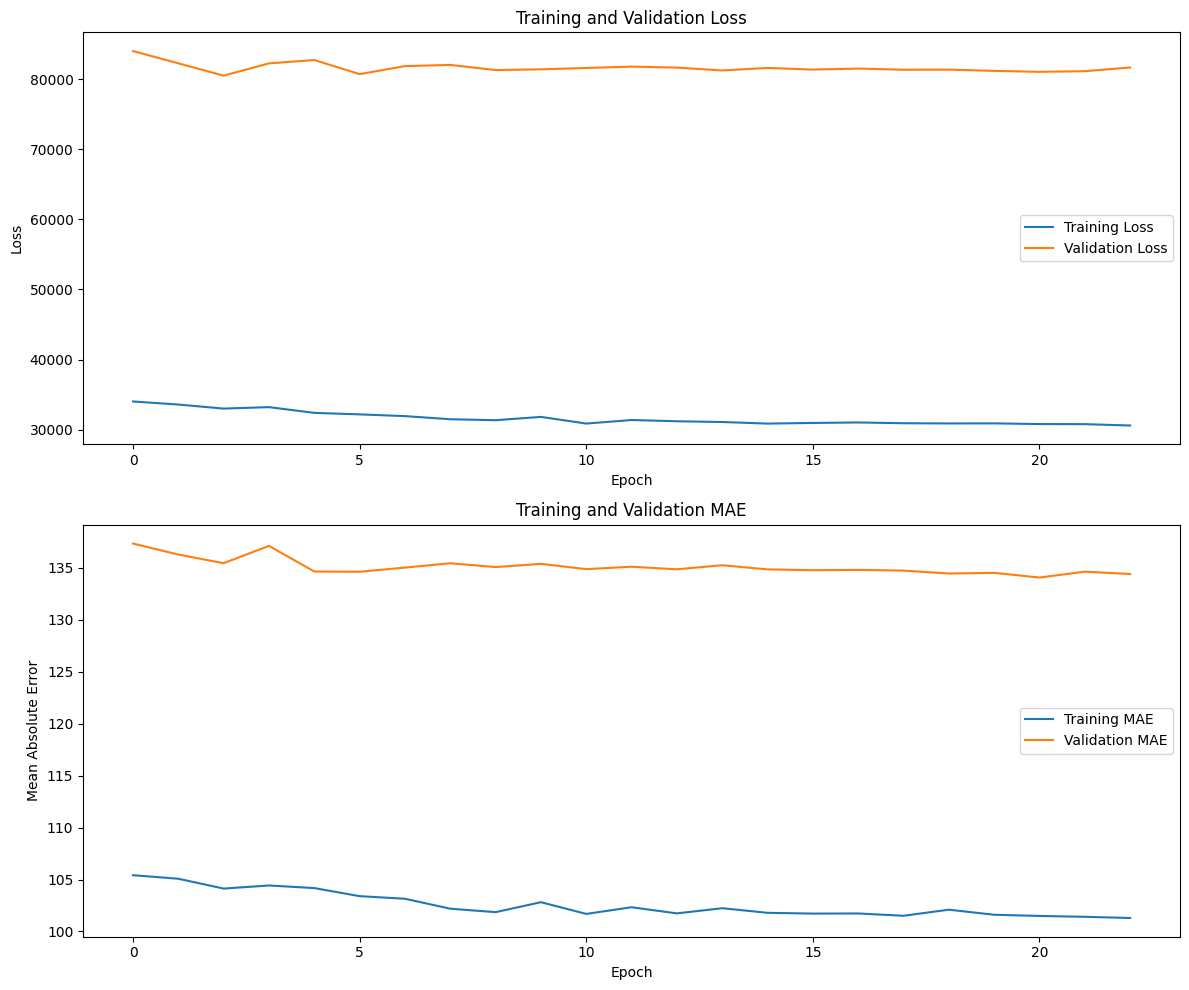

In [9]:
# Extracting values from the training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
mae_values = history.history['mean_absolute_error']
val_mae_values = history.history['val_mean_absolute_error']

# Setting up the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plotting loss values
ax1.plot(loss_values, label='Training Loss')
ax1.plot(val_loss_values, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting MAE values
ax2.plot(mae_values, label='Training MAE')
ax2.plot(val_mae_values, label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

# Displaying the plots
plt.tight_layout()
plt.show()

In [12]:
#Save finetuned model
model_path_fine_tuned = "fine_tuned_resnet_weights.h5"
model.save(model_path_fine_tuned)

# Use the function you defined earlier to upload back to GCS
gcs_path_fine_tuned = "gs://xcob-bucket-1/dataset/model/fine_tuned_resnet_weights.h5"
upload_model_to_gcs_using_gsutil(model_path_fine_tuned, gcs_path_fine_tuned)


Model successfully uploaded to gs://xcob-bucket-1/dataset/model/fine_tuned_resnet_weights.h5


In [6]:
def download_file_from_gcs(gcs_path, local_path):
    client = storage.Client()
    bucket_name = gcs_path.split("//")[1].split("/")[0]
    blob_name = gcs_path.split(bucket_name + "/")[1]
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(local_path)

checkpoint_path = "gs://xcob-bucket-1/dataset/model/fine_tuned_resnet_weights.h5"
local_model_path = "downloaded_model.h5"
download_file_from_gcs(checkpoint_path, local_model_path)

model = tf.keras.models.load_model(local_model_path)

In [16]:
# Download the model weights from GCS to local/VM
downloaded_weights_path = "fine_tuned_resnet_weights.h5"
#tf.keras.utils.get_file(downloaded_weights_path, gcs_path_fine_tuned)

# Load the weights
model.load_weights(downloaded_weights_path)
# First, get the predictions
predictions = model.predict(val_dataset)

# Assuming you can extract y_test (the ground truth) from your test_dataset:
y_test_list = []
for _, label_batch in val_dataset:
    y_test_list.extend(label_batch.numpy())
y_test = np.array(y_test_list)

# Define the threshold for binarisation
threshold = 0.5

from scipy.ndimage import label

def count_buildings(binary_mask):
    labeled_mask, num_features = label(binary_mask)
    return num_features

total_predicted_building_count = 0
total_actual_building_count = 0

for idx in range(len(y_test)):
    binary_predictions = (predictions[idx] > threshold).astype(int)
    predicted_building_count = count_buildings(binary_predictions)
    actual_building_count = count_buildings(y_test[idx])
    total_predicted_building_count += predicted_building_count
    total_actual_building_count += actual_building_count
    print(f"Sample {idx}: {predicted_building_count} buildings predicted and {actual_building_count} from binary mask.")

Streaming output truncated to the last 5000 lines.
Sample 6151: 1 buildings predicted and 0 from binary mask.
Sample 6152: 1 buildings predicted and 1 from binary mask.
Sample 6153: 1 buildings predicted and 0 from binary mask.
Sample 6154: 1 buildings predicted and 1 from binary mask.
Sample 6155: 1 buildings predicted and 1 from binary mask.
Sample 6156: 1 buildings predicted and 1 from binary mask.
Sample 6157: 1 buildings predicted and 1 from binary mask.
Sample 6158: 1 buildings predicted and 1 from binary mask.
Sample 6159: 1 buildings predicted and 1 from binary mask.
Sample 6160: 1 buildings predicted and 1 from binary mask.
Sample 6161: 1 buildings predicted and 1 from binary mask.
Sample 6162: 1 buildings predicted and 1 from binary mask.
Sample 6163: 1 buildings predicted and 1 from binary mask.
Sample 6164: 1 buildings predicted and 1 from binary mask.
Sample 6165: 1 buildings predicted and 1 from binary mask.
Sample 6166: 1 buildings predicted and 1 from binary mask.
Sampl

In [12]:
#Evaluate the model
loss, mae = model.evaluate(val_dataset)
print(f"Test Loss: {loss}, Test MAE: {mae}")

175/175 [==============================] - 246s 1s/step - loss: 80481.2812 - mean_absolute_error: 135.4311
Test Loss: 80481.28125, Test MAE: 135.43113708496094


In [11]:
print(f"Total predicted buildings: {total_predicted_building_count}")
print(f"Total actual buildings from binary masks: {total_actual_building_count}")

Total predicted buildings: 10981
Total actual buildings from binary masks: 10055


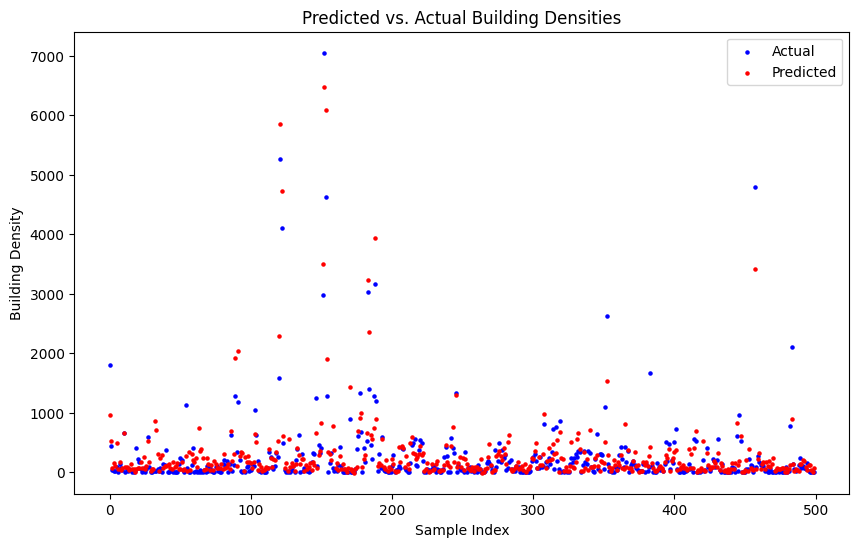

In [18]:
import matplotlib.pyplot as plt

# Get predicted and actual values
predicted_values = predictions.squeeze()
actual_values = y_test

# Visualise the first 100 samples for clarity
plt.figure(figsize=(10,6))
plt.scatter(range(500), actual_values[:500], color='blue', label='Actual', s=5)
plt.scatter(range(500), predicted_values[:500], color='red', label='Predicted', s=5)
plt.title('Predicted vs. Actual Building Densities')
plt.xlabel('Sample Index')
plt.ylabel('Building Density')
plt.legend()
plt.show()


In [14]:
print(y_test.shape)
print(predictions.shape)

(11151,)
(11151, 1)


Counting error:
Error
=
(total predicted building count
−
total actual building count) /
total actual building count
×
100
Error=
total actual building count
total predicted building count−total actual building count
​
 ×100

In [14]:
counting_error_percentage = ((total_predicted_building_count - total_actual_building_count) / total_actual_building_count) * 100
print(f"Counting error: {counting_error_percentage:.2f}%")

Counting error: 9.10%
